In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd

In [47]:
def LatLonAlt2XYZ(Lat : float,Lon : float,Alt : float) -> tuple:
    a_e = 6378137
    ecc = 0.081819190842622
    ksi = 1.0 / np.sqrt(1 - ecc * ecc * np.sin(Lat) * np.sin(Lat))
    X = (a_e * ksi + Alt) * np.cos(Lat) * np.cos(Lon)
    Y = (a_e * ksi + Alt) * np.cos(Lat) * np.sin(Lon)
    Z = (a_e * ksi * (1 - ecc * ecc) + Alt) * np.sin(Lat)
    return X, Y, Z

In [48]:
def CalcGravity(X:float,Y:float,Z:float)->np.array:
    t2 = X ** 2.0
    t3 = Y ** 2.0
    t4 = Z ** 2.0
    t5 = t2 + t3 + t4
    t6 = 1.0 / t5 ** (3.0 / 2.0)
    t7 = 1.0 / t5 ** (5.0 / 2.0)
    t8 = 1.0 / t5 ** (7.0 / 2.0)
    g = np.array([
       X * 5.3174941173225e-9-X * t6 * 3.9860142624e14-X * t7 * 2.633274580483414e25 + X * t4 * t8 * 1.316637290241707e26,
       Y * 5.3174941173225e-9 - Y * t6 * 3.9860142624e14 - Y * t7 * 2.633274580483414e25 + Y * t4 * t8 * 1.316637290241707e26,
       Z * t6 * -3.9860142624e14 - Z * t7 * 7.899823741450242e25 + Z * t4 * t8 * 1.316637290241707e26])
    return g

In [49]:
def SkewSymmMatr(a : np.array) -> np.array:
    Ax= np.array(
        [[0.0,-a[2],a[1]],
        [a[2],0.0,-a[0]],
        [-a[1],a[0],0.0]])
    return Ax

In [50]:
def cross(a : np.array ,b : np.array) -> np.array:
    axb = SkewSymmMatr(a) @ b
    return axb

In [51]:
def twoPiBound(heading : float) -> float:
    if heading < 0:
        heading = heading + 2.0 * np.pi

    return heading

In [52]:
def DCM_bn(heading : float, pitch : float, roll : float) -> np.array:
    sz = np.sin(pitch)
    cz = np.cos(pitch)
    sy = np.sin(-heading)
    cy = np.cos(-heading)
    sx = np.sin(roll)
    cx = np.cos(roll)

    Cx = np.array([[1, 0, 0],[0, cx, sx],[0, -sx, cx]],dtype = np.float64)
    Cy = np.array([[cy, 0, -sy],[0, 1, 0],[sy, 0, cy]],dtype = np.float64)
    Cz = np.array([[cz, sz, 0],[-sz, cz, 0],[0, 0, 1]],dtype = np.float64)

    Cnb = Cx @ Cz @ Cy

    return Cnb.T

In [53]:
def Calc_F_C_N(B : float,h : float,a_e : float,ecc2 : float) -> np.array:
    sinB = np.sin(B)
    sinB2 = sinB * sinB

    R_N = a_e * (1 - ecc2) / (1 - ecc2 * sinB2) ** 1.5 + h

    R_E = a_e / np.sqrt(1 - ecc2 * sinB2) + h

    F_C_N = np.array([
        [0.0,0.0,1.0 / R_E],
        [0.0,0.0,np.tan(B)/R_E],
        [-1.0/R_N,0.0,0.0]])

    return F_C_N

In [54]:
def CalcDCMnue_align(Pos : list,fb : np.array,om_ib : np.array) -> np.array:
    #nue->ned
    fb =np.array([fb[0],fb[2],-fb[1]])
    om_ib = np.array([om_ib[0],om_ib[2],-om_ib[1]])

    om_ie = 7.292115e-5

    cosB = np.cos(Pos[0])
    sinB = np.sin(Pos[0])
    cosL = np.cos(Pos[1])
    sinL = np.sin(Pos[1])

    Lat = Pos[0]

    (X,Y,Z) = LatLonAlt2XYZ(Pos[0],Pos[1],Pos[2])
    gravity = CalcGravity(X,Y,Z)

    gt = -cosL*sinB*gravity[0] - sinL*sinB*gravity[1] + cosB*gravity[2]
    gn = -(cosL*cosB*gravity[0] + sinL*cosB*gravity[1] + sinB*gravity[2])

    b1 = -fb
    b2 = om_ib
    b3 = cross(b1, b2)

    Mb = np.array([b1,b2,b3])

    Mn = np.array([[np.sin(Lat) / (gn * np.cos(Lat) + gt * np.sin(Lat)),gn / (gn * om_ie * np.cos(Lat) + gt * om_ie * np.sin(Lat)),0 ],
                  [0,0, 1 / (gn * om_ie * np.cos(Lat) + gt * om_ie * np.sin(Lat))],
                  [np.cos(Lat) / (gn * np.cos(Lat)+ gt * np.sin(Lat)),  -gt / (gn * om_ie * np.cos(Lat) + gt * om_ie * np.sin(Lat)), 0 ]] )

    R_nb = Mn @ Mb

    DCM = R_nb.T

    return DCM

In [55]:
def threeaxisrot(r11, r12, r21, r31, r32):
    r1 = np.arctan2(r11,r12)
    r2 = np.arcsin(r21)
    r3 = np.arctan2(r31,r32)
    return r1,r2,r3

def EulerFromDCMnue(dcm):
    (r1, r2, r3) = threeaxisrot(dcm[0, 1],dcm[0,0], -dcm[0, 2],dcm[1, 2], dcm[2, 2])
    return (r1, r2, r3)

### Загрузка данных

In [56]:
mat = loadmat('data/nav.binB_03.mat')
data_df = pd.DataFrame(mat['UAV'])
data = data_df.to_numpy().T
data = np.delete(data, 0, 1)
data = data[405500:,:]
n = data.shape[0]
acc = data[:,9:12]
gyro = data[:,12:15]

GPSQuality = data[:,23]
GPS = data[:,17:23]
GPS[:,0:2] = GPS[:,0:2] * np.pi / 180

StatusMS = data[:, 33]
MagnSens = data[:, 30:33] * 10
MagnSens[:,1:3] = -1 * MagnSens[:,1:3]

dt = 1 / 100
deg_to_rad = np.pi/180
rad_to_deg = 1/deg_to_rad

## Выставка

In [57]:
Alignment = 60000
Lat = GPS[Alignment,0]
Lon = GPS[Alignment,1]
Alt = GPS[Alignment,2]
W_NUE = GPS[Alignment,3:6]
W_NUE_old = W_NUE
Lat_old = Lat
Alt_old = Alt
Roll = 0
Pitch = 0
Heading = 0
C_B_N = np.eye(3)
NavState = np.zeros(26)
MS_mean_count = 0
gyros_mean_count = 0
accels_mean = np.zeros(3)
gyros_mean = np.zeros(3)
MS_mean = np.zeros(3)

### Накопление данных

In [58]:
for i in range(Alignment):
    accels_mean = accels_mean + acc[i, :]
    gyros_mean = gyros_mean + gyro[i, :]
    gyros_mean_count = gyros_mean_count + 1
    if (StatusMS[i] == 2):
        MS_mean = MS_mean + MagnSens[i]
        MS_mean_count = MS_mean_count + 1

### Расчет углов крена и тангажа,определение курса методом гирокомпасирования

In [59]:
accels_mean = (accels_mean/gyros_mean_count) / dt # Осреднение показаний акселерометров. Используется счетчик данных гироскопа
gyros_mean = (gyros_mean/gyros_mean_count) / dt # Осреднение показаний гироскопов + пересчет в рад/сек
MS_mean = (MS_mean / MS_mean_count)
# если датчики - ВОГ, то проводится определение курса методом гирокомпасирования
Rbn = CalcDCMnue_align([Lat,Lon,Alt],accels_mean,gyros_mean)
(Heading, Pitch, Roll) = EulerFromDCMnue(Rbn)
C_B_N = DCM_bn(Heading,Pitch,Roll) # Расчет DCM
Heading = twoPiBound(Heading)  # Ограничение
C_I_B = C_B_N.T
C_I_N = C_B_N.T
Sensors = np.zeros((6,),dtype = np.float64)

In [60]:
Sensors

array([0., 0., 0., 0., 0., 0.])

In [61]:
print("Параметры после выставки")
print("Курс ")
print(Heading * (180 / np.pi))
print("Тангаж ")
print(Pitch * (180 / np.pi))
print("Крен ")
print(Roll * (180 / np.pi))
print("Широта ")
print(Lat * (180 / np.pi))
print("Долгота ")
print(Lon * (180 / np.pi))
print("Высота ")
print(Alt)
print("W_N ")
print(W_NUE[0])
print("W_U ")
print(W_NUE[1])
print("W_E ")
print(W_NUE[2])

Параметры после выставки
Курс 
333.2617518321868
Тангаж 
6.023054025873441
Крен 
-0.8737296834068249
Широта 
54.9797978
Долгота 
37.663690100000004
Высота 
192.796
W_N 
-0.054999999701976776
W_U 
-0.0430000014603138
W_E 
0.08799999952316284


In [62]:
NavState = np.array([Lat,Lon,Alt,          # Широта, долгота, геодезическая высота
                   W_NUE[0],W_NUE[1],W_NUE[2],
                    Roll,Pitch,Heading])           # Скорость на север, вверх, на восток

In [63]:
# Статические переменные
Om_e = 7.292115e-5
E = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]],dtype = np.float64)
# Используется ПЗ-90
a_e = 6378136.0
ecc = 0.0818191065283638
ecc2 = ecc * ecc
iter = 0
delta_v_array = np.zeros((3,4))
delta_alfa_array = np.zeros((3,4))

In [64]:
delta_v_array

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [65]:
def SINS(NavState : np.array, Sensors : np.array, dt : float, C_i_b : np.array, C_i_n : np.array , gt : float) -> tuple:

    global Om_e
    global E
    # Используется ПЗ-90
    global a_e
    global ecc2
    global iter
    global delta_v_array
    global delta_alfa_array

    # переменные квази-скоростей и квази-угллов
    delta_v = Sensors[0:3] # выходной сигнал акселерометра по осям чувствительности (x,y,z) на текущем такте расчетов
    delta_alpha = Sensors[3:6] # выходной сигнал гироскопов (скорость) по оси (x,y,z) на текущем такте расчетов
    delta_v_array[0:3,iter] = delta_v
    delta_alfa_array[0:3,iter] = delta_alpha
    iter += 1

    if iter == 4:

        B = NavState[0]
        L = NavState[1]  # текущая  долгота ВС в выбранной СК
        h = NavState[2]  # текущая  геодезическая высота ВС относительно эллипсоида выбранной СК
        W = NavState[3:6] # текущий вектор земной скорости ВС (N,U,E)
        sinB = np.sin(B)
        cosB = np.cos(B)
        sinL = np.sin(L)
        cosL = np.cos(L)
        sinB2 = sinB * sinB
        R_N = a_e * (1 - ecc2) / (1 - ecc2 * sinB2) ** 1.5 + h
        R_E = a_e / np.sqrt(1 - ecc2 * sinB2) + h
        # Расчет вектора конечного поворота Эйлера (body)
        alfa_1_2 = np.array([delta_alfa_array[0,0],delta_alfa_array[1,0], delta_alfa_array[2,0]])+np.array([delta_alfa_array[0,1],delta_alfa_array[1,1], delta_alfa_array[2,1]])
        alfa_3_4 = np.array([delta_alfa_array[0,2],delta_alfa_array[1,2], delta_alfa_array[2,2]])+np.array([delta_alfa_array[0,3],delta_alfa_array[1,3], delta_alfa_array[2,3]])
        alfa = alfa_1_2 + alfa_3_4
        beta = 2 / 3 * cross(alfa_1_2,alfa_3_4) # коннинг
        alfa = alfa + beta # вектор порота body эйлера
        skew_alfa = SkewSymmMatr(alfa) # Коссосиметричная матрица
        mod_alpha = np.sqrt(alfa[0] * alfa[0] + alfa[1] * alfa[1] + alfa[2] * alfa[2])
        mod_alpha2 = mod_alpha * mod_alpha
        # Расчет вектора конечного поворота (скорости) Эйлера (Navigation)
        omega_IE_N = np.array([Om_e * cosB, Om_e * sinB, 0.0 ])
        F_C_N = Calc_F_C_N(B, h, a_e, ecc2)
        omega_sum = omega_IE_N + F_C_N @ W
        skew_omega = SkewSymmMatr(omega_sum)
        # нахождение МНК из body t-1 в body t при помощи решения уравенения Пуасона
        C_b_b = E + (1 - mod_alpha2 / 6) * skew_alfa + (0.5 - mod_alpha2/24) * skew_alfa @ skew_alfa
        C_i_b = C_b_b @ C_i_b  # Получили МНК из body в инерциальную в данный такт
        # нахождение МНК из навигационной СК t-1 в навигационную СК t при помощи решения уравенения Пуасона
        C_n_n = E - dt * skew_omega + (dt**2) / 2 * skew_omega @ skew_omega
        C_i_n = C_n_n @ C_i_n
        C_b_n = C_i_n @ C_i_b.T
        #нормализация и ортогонализация мнк
        #C_i_b = (E - ((1.0 / 2.0) * ( C_i_b @  C_i_b.T - E))) @  C_i_b
        #C_i_n = (E - ((1.0 / 2.0) * ( C_i_n @  C_i_n.T - E))) @  C_i_n
        #C_b_n = (E - ((1.0 / 2.0) * ( C_b_n @  C_b_n.T - E))) @  C_b_n
        #нахождение приращения линейных скоростей методом Рунге-Кутта 4-го порядка
        delta_W = np.array([0,0,0])
        for i in range(4):
            skew_delta_alfa = SkewSymmMatr(delta_alfa_array[0:3,i])
            w_b = delta_v_array[0:3,i]
            k_1 = w_b - skew_delta_alfa @ delta_W
            k_2 = w_b - skew_delta_alfa @ (delta_W + (dt / 2) * k_1)
            k_3 = w_b - skew_delta_alfa @ (delta_W + (dt / 2) * k_2)
            k_4 = w_b - skew_delta_alfa @ (delta_W + dt * k_3)
            delta_W = delta_W + (k_1+2*k_2+2*k_3+k_4)/6

        delta_W_n = C_b_n @ delta_W

        omega = omega_IE_N + F_C_N @ W
        W_N = W[0] + delta_W_n[0] + dt * (-(omega_IE_N[2] + omega[2]) * W[2] + omega[2] * W[1])
        W_U = W[1] + delta_W_n[1] + dt * ((omega_IE_N[0] + omega[0]) * W[2] + omega[2] * W[0] - gt)
        W_E = W[2] + delta_W_n[2] + dt * ((omega_IE_N[2] + omega[2]) * W[0] - (omega_IE_N[0] + omega[0])*W[1])

        Lat = B + dt * W_N / R_N # Широта
        Lon = L + dt * W_E / R_E # долгота
        Alt = 0
        roll = np.arctan2(-C_b_n[1,2], C_b_n[1, 1])
        pitch = np.arctan(C_b_n[1, 0] / np.sqrt(C_b_n[1, 1] * C_b_n[1, 1] + C_b_n[1, 2] * C_b_n[1, 2]))
        heading = np.arctan2(C_b_n[2, 0], C_b_n[0, 0])
        heading = twoPiBound(heading) # Ограничение

        NavState = np.array([Lat,Lon,Alt,          # Широта, долгота, геодезическая высота
                   W_N,W_U,W_E,            # Скорость на север, вверх, на восток
                    roll,pitch,heading])           # Крен , тангаж , курс

        delta_v_array = np.zeros((3,4))
        delta_alfa_array = np.zeros((3,4))
        iter = 0
    return NavState , C_i_b , C_i_n

In [66]:
queue_Lat = np.zeros(n)
queue_Lon = np.zeros(n)
queue_pitch = np.zeros(n)
queue_roll = np.zeros(n)
queue_heading = np.zeros(n)
queue_Alt = np.zeros(n)
queue_W_N = np.zeros(n)
queue_W_U = np.zeros(n)
queue_W_E = np.zeros(n)
queue_Lat[:Alignment] = Lat
queue_Lat[:Alignment] = Lon
queue_pitch[:Alignment] = Pitch
queue_roll[:Alignment] = Roll
queue_heading[:Alignment] = Heading
queue_W_N[:Alignment] = W_NUE[0]
queue_W_E[:Alignment] = W_NUE[2]
dt = 1 / 25
gt = 9.81
## ======================= Работа ============================
for i in range(Alignment,n):
    Sensors[0:3] = acc[i,:] # выходной сигнал акселерометра по осям чувствительности (x,y,z) на текущем такте расчетов
    Sensors[3:6] = gyro[i,:] # выходной сигнал гироскопов (скорость) по оси (x,y,z) на текущем такте расчетов
    NavState[2] = 0
    NavState[4] = 0
    queue_Lat[i] = NavState[0]
    queue_Lon[i] = NavState[1]
    queue_roll[i] = NavState[6]
    queue_pitch[i] = NavState[7]
    queue_heading[i] = NavState[8]
    queue_W_N[i] = NavState[3]
    queue_W_U[i] = NavState[4]
    queue_W_E[i] = NavState[5]
    queue_Alt[i] = NavState[2]
    (NavState , C_i_b , C_i_n) = SINS(NavState, Sensors, dt, C_I_B, C_I_N, gt)

In [67]:
n = queue_Lat.shape[0]
s = 60000
d = 230000
N = n-d-s
T = N / 100 # c
t = np.linspace(0,T,N)

In [68]:
out_queue_Lat = queue_Lat[s:n-d] * 180 / np.pi
out_queue_Lon = queue_Lon[s:n-d] * 180 / np.pi
out_queue_pitch = queue_pitch[s:n-d]  * 180 / np.pi
out_queue_roll = queue_roll[s:n-d]  * 180 / np.pi
out_queue_W_E = queue_W_E[s:n-d]
out_queue_W_N = queue_W_N[s:n-d]
out_queue_heading = queue_heading[s:n-d]  * 180 / np.pi
out_queue_GPS_Lat = GPS[s:n-d,0]  * (180 / np.pi)
out_queue_GPS_Lon = GPS[s:n-d,1]  * (180 / np.pi)
out_queue_GPS_W_N = GPS[s:n-d,3]
out_queue_GPS_W_E = GPS[s:n-d,5]

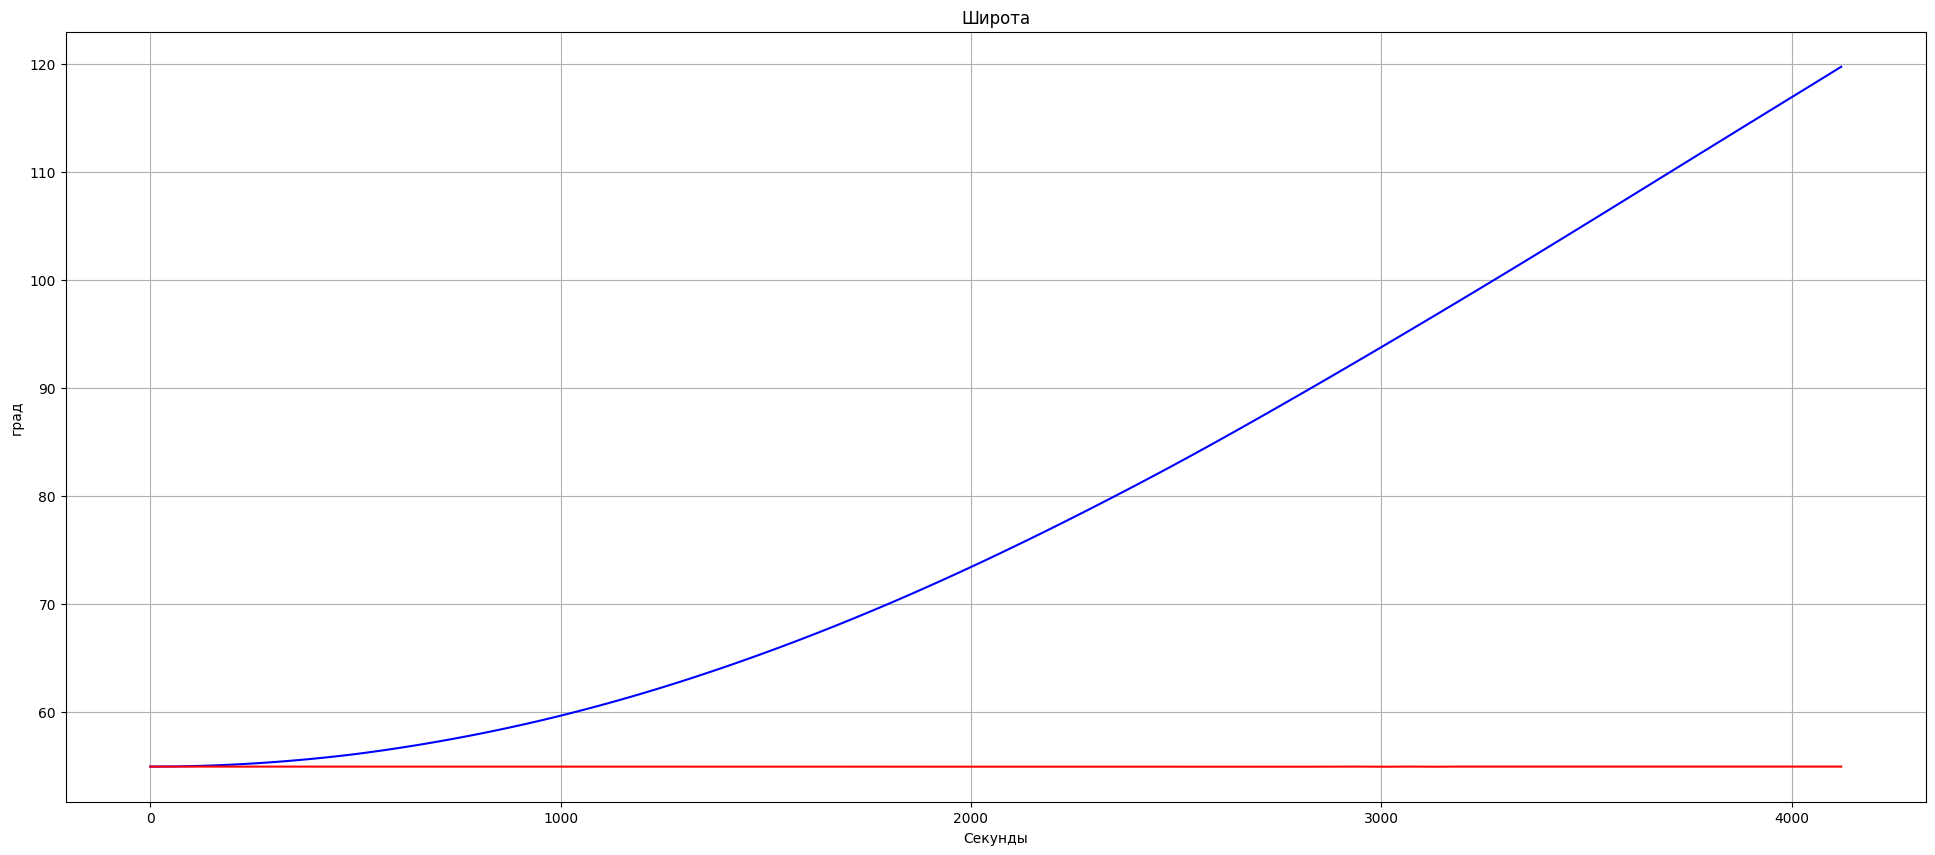

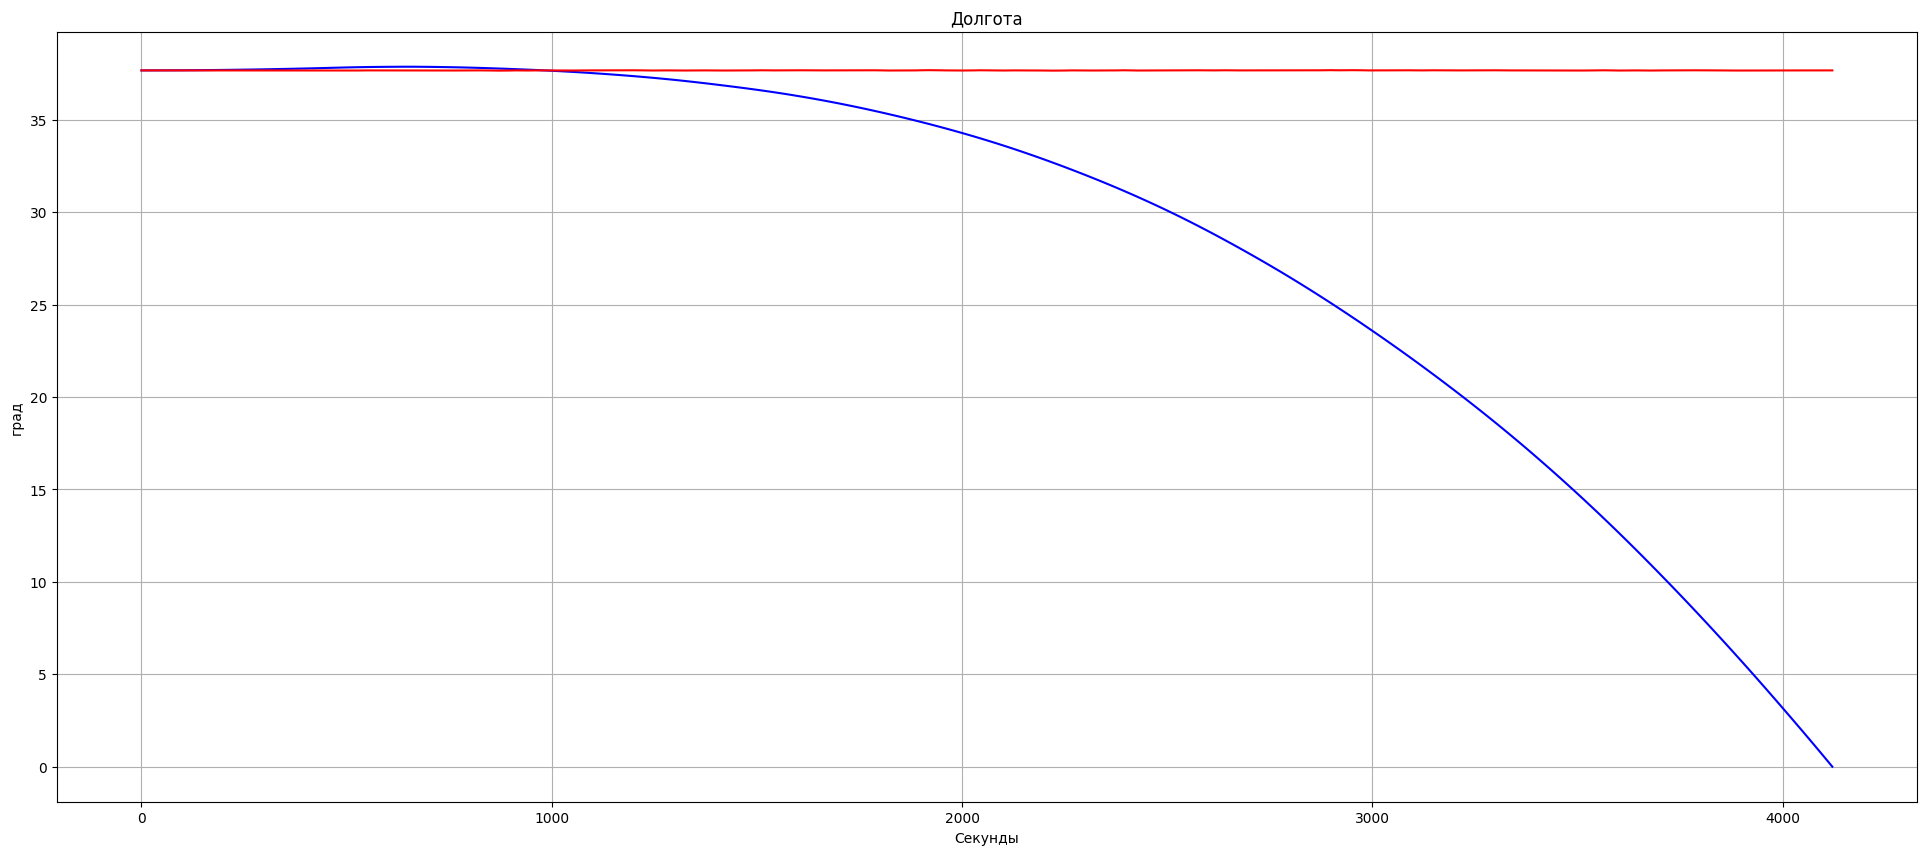

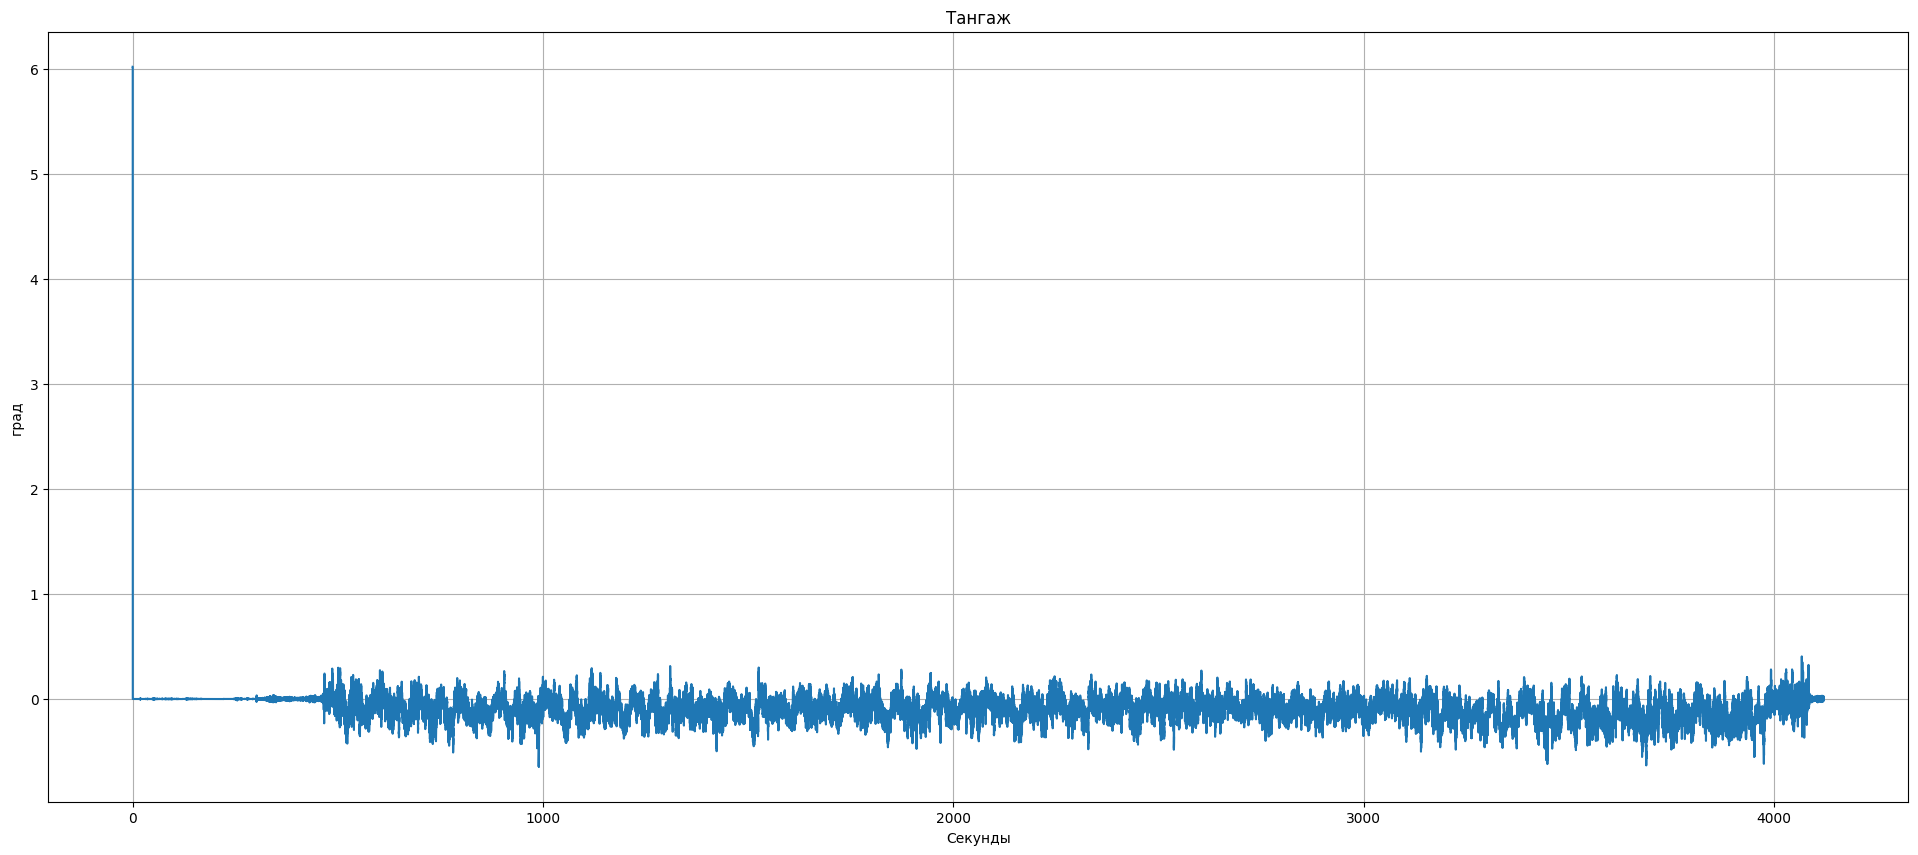

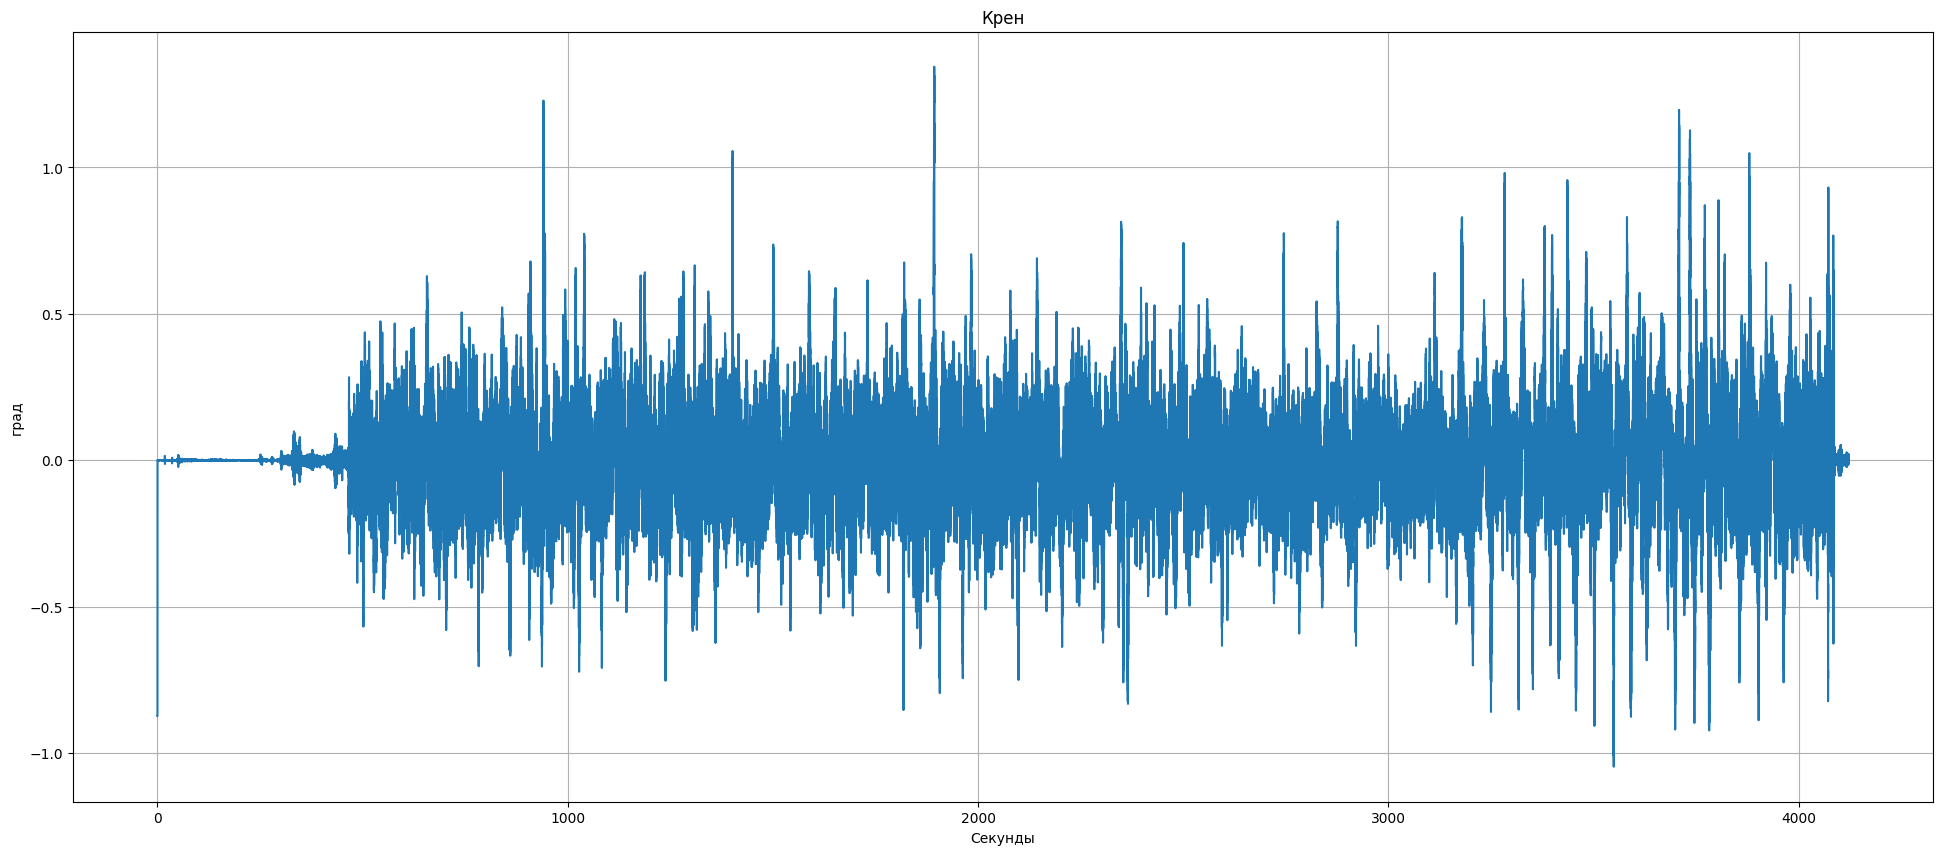

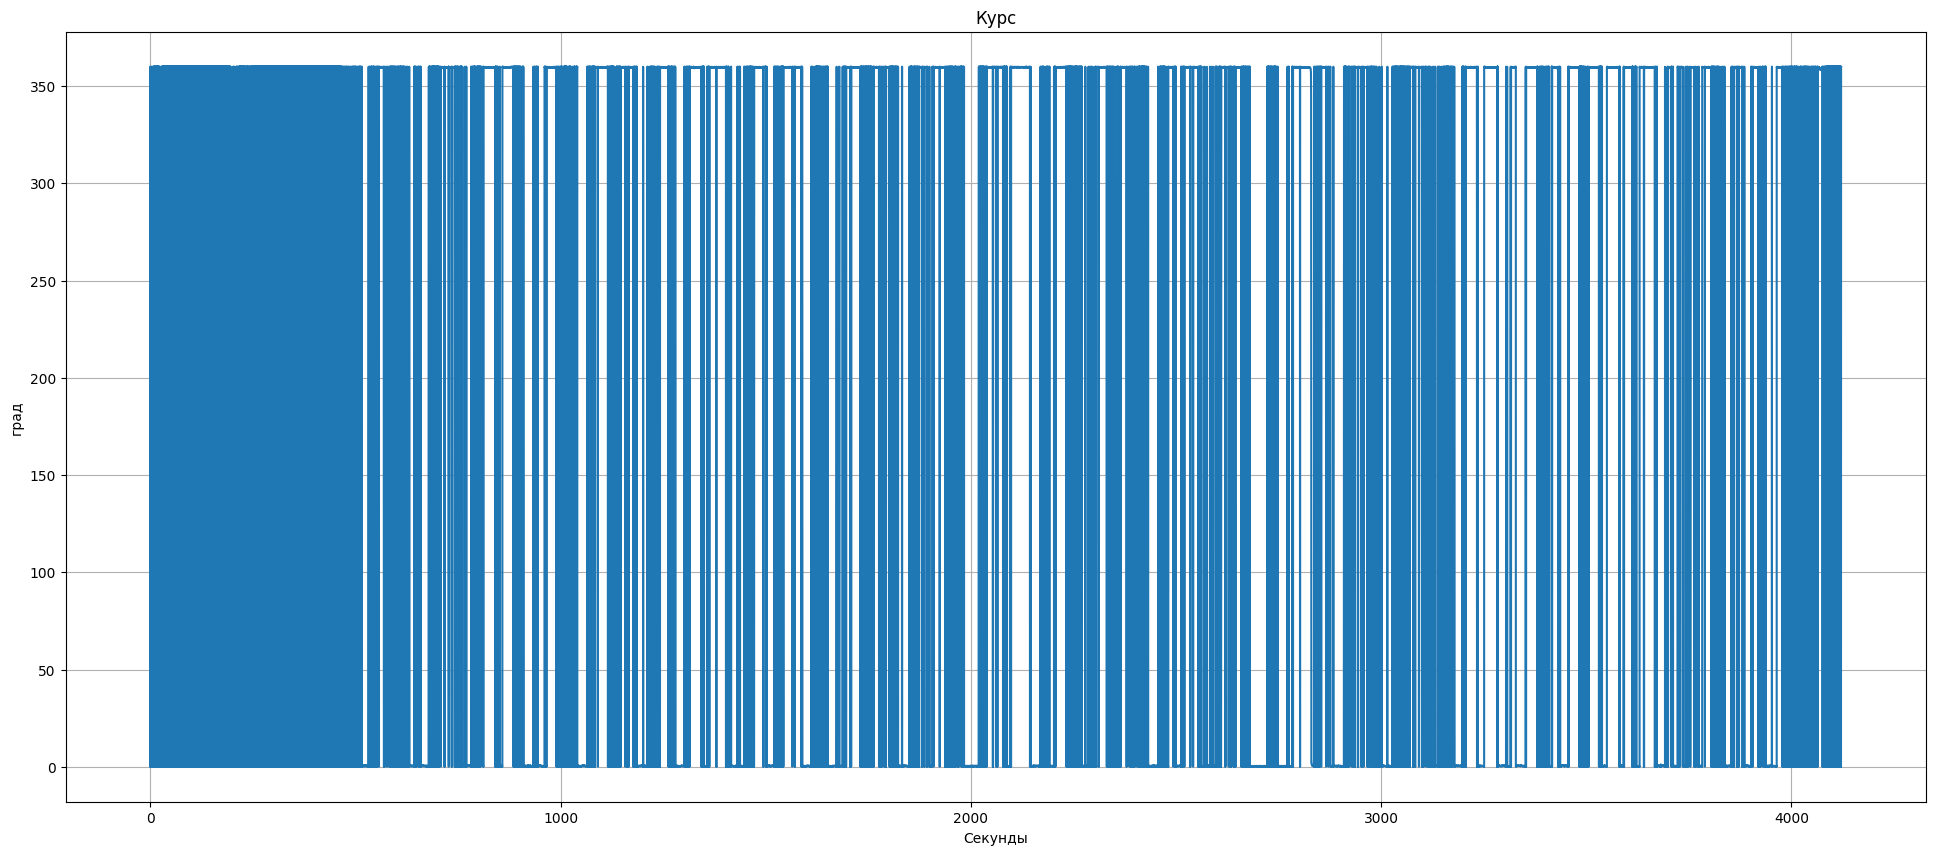

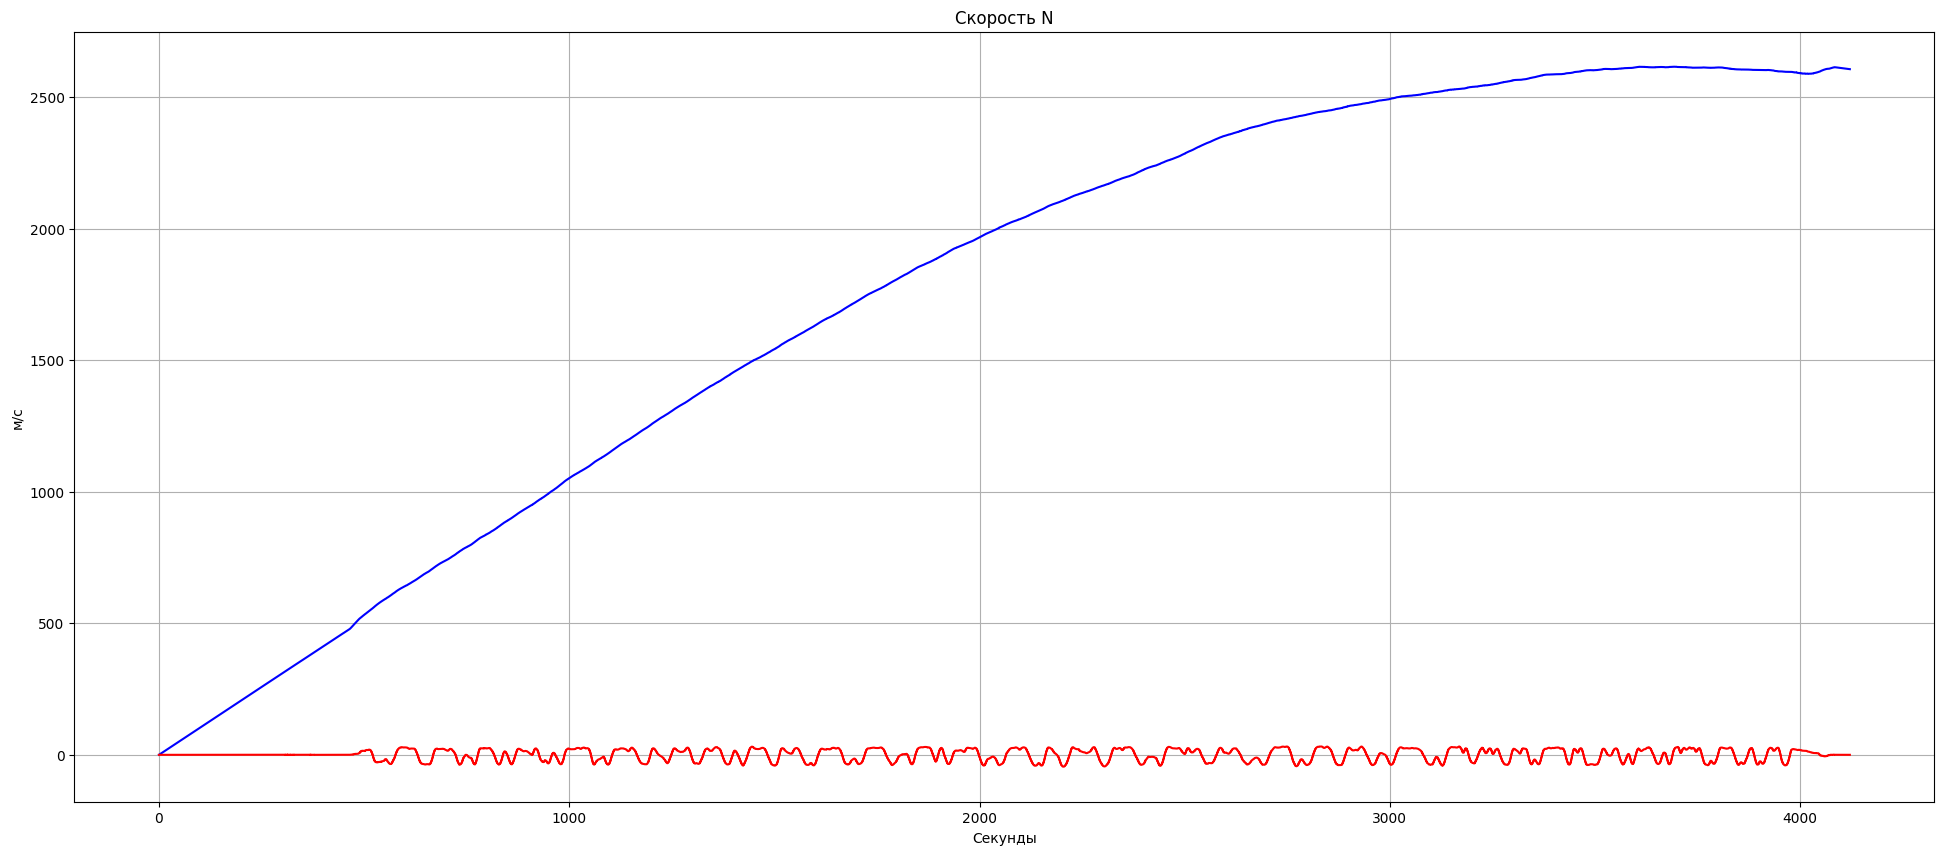

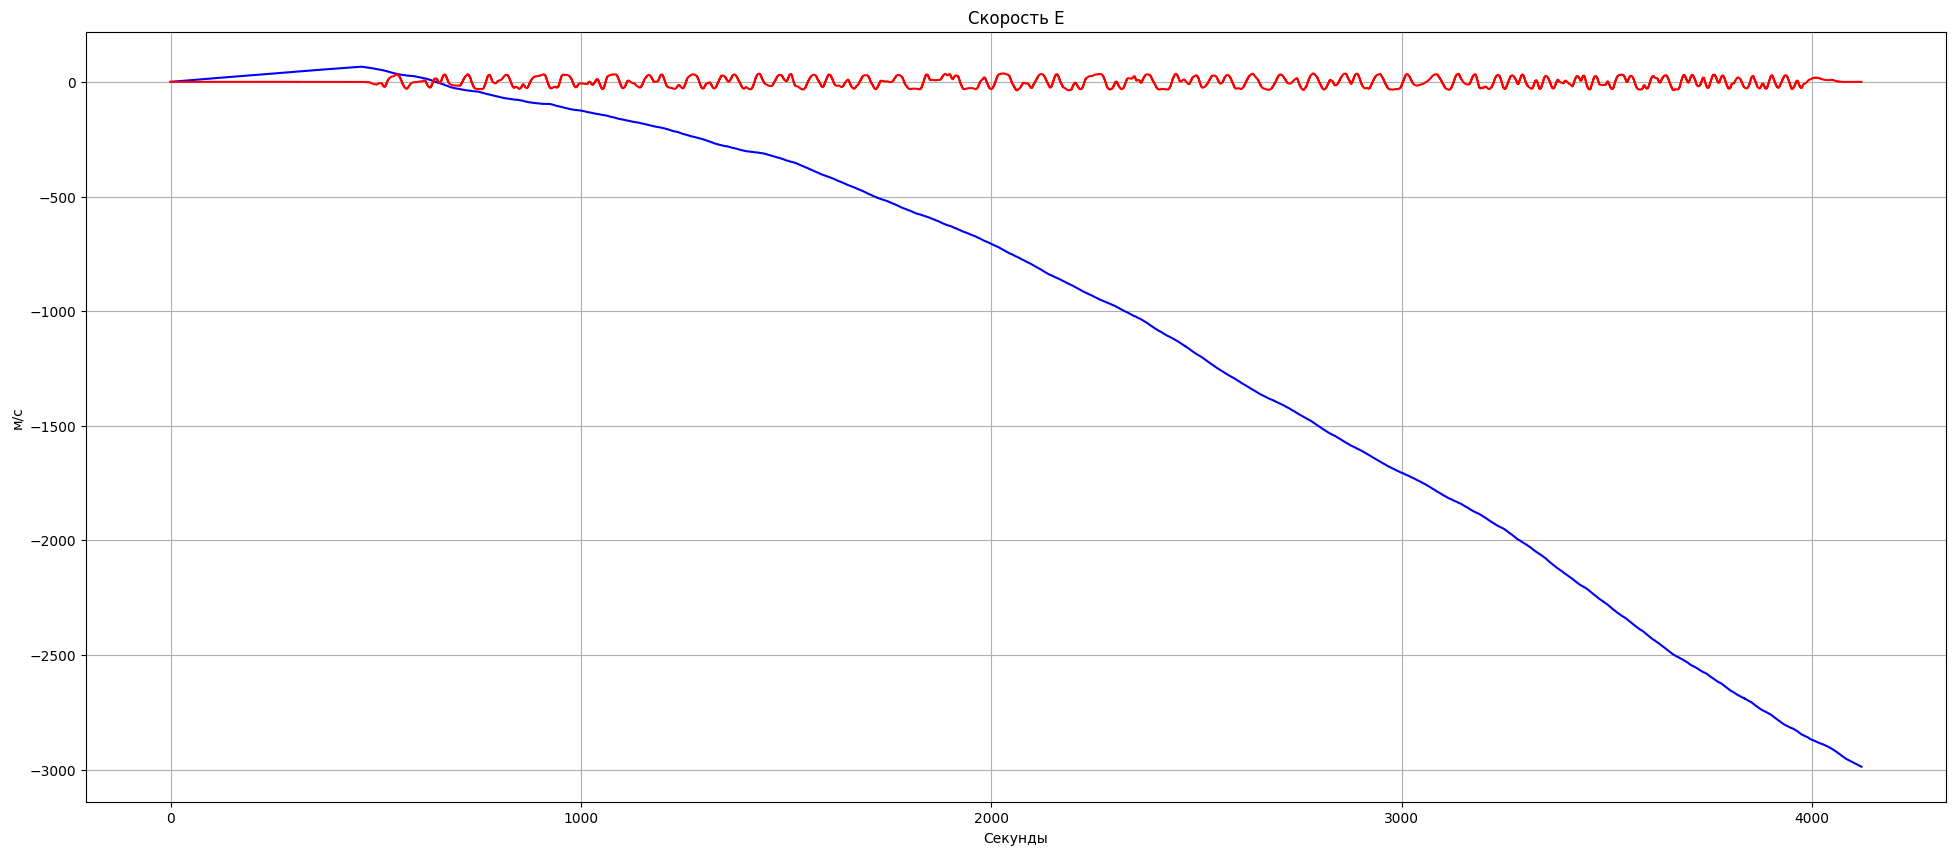

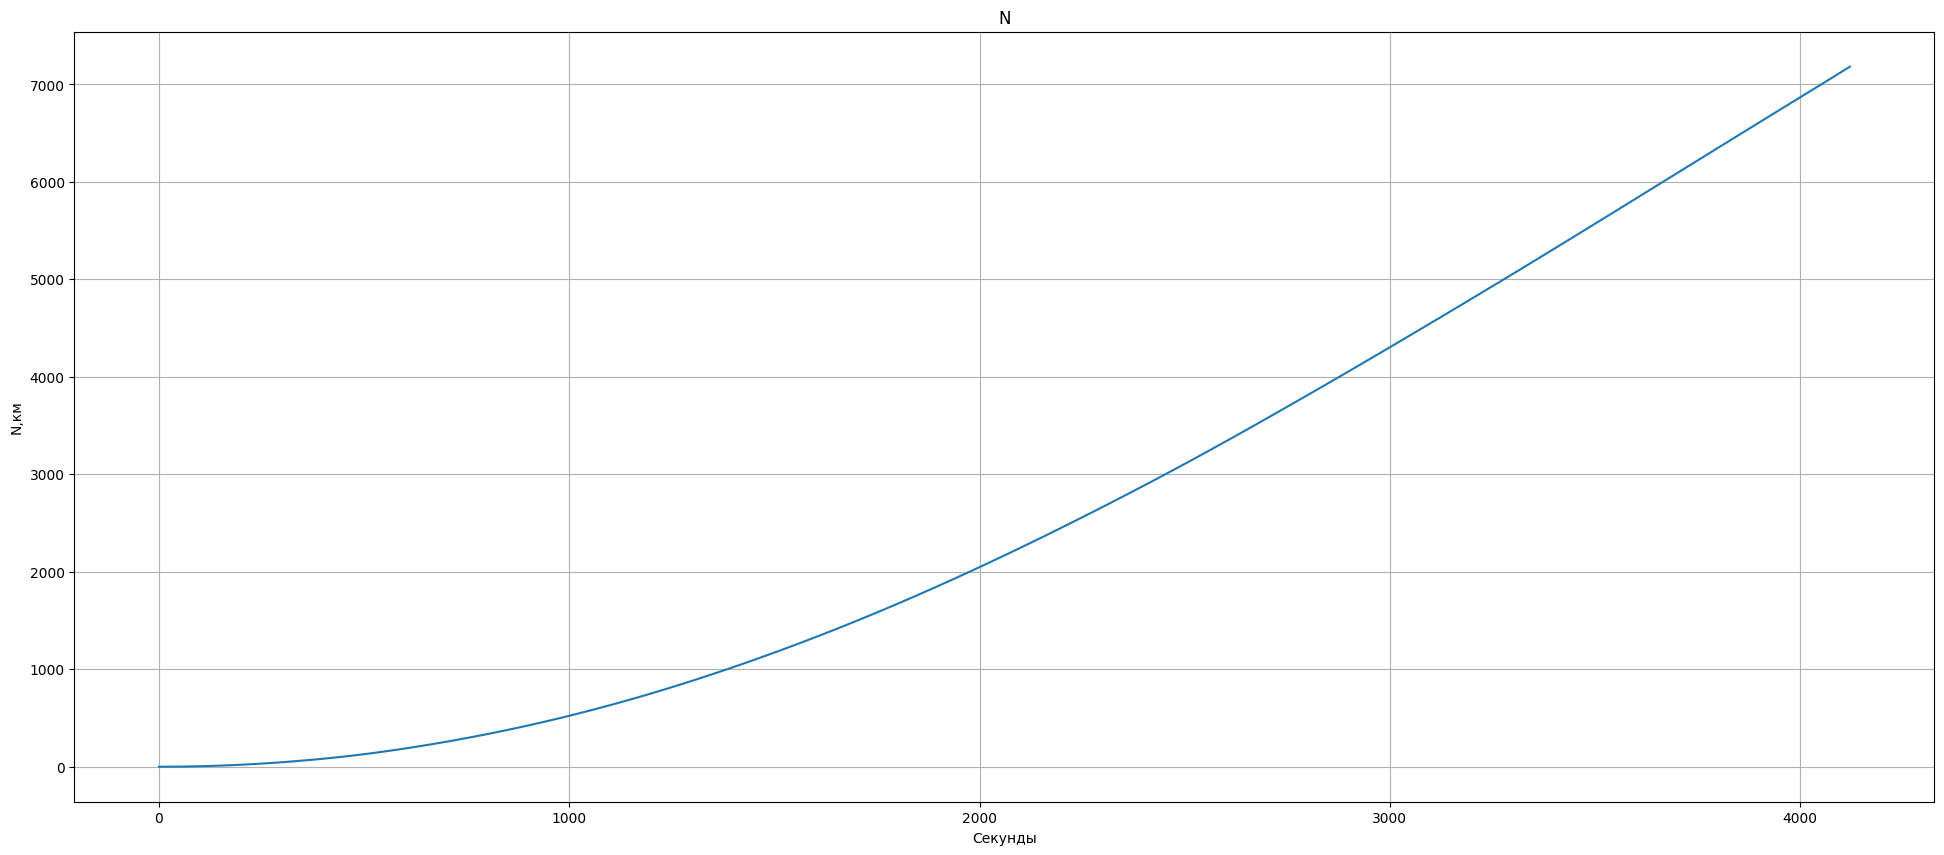

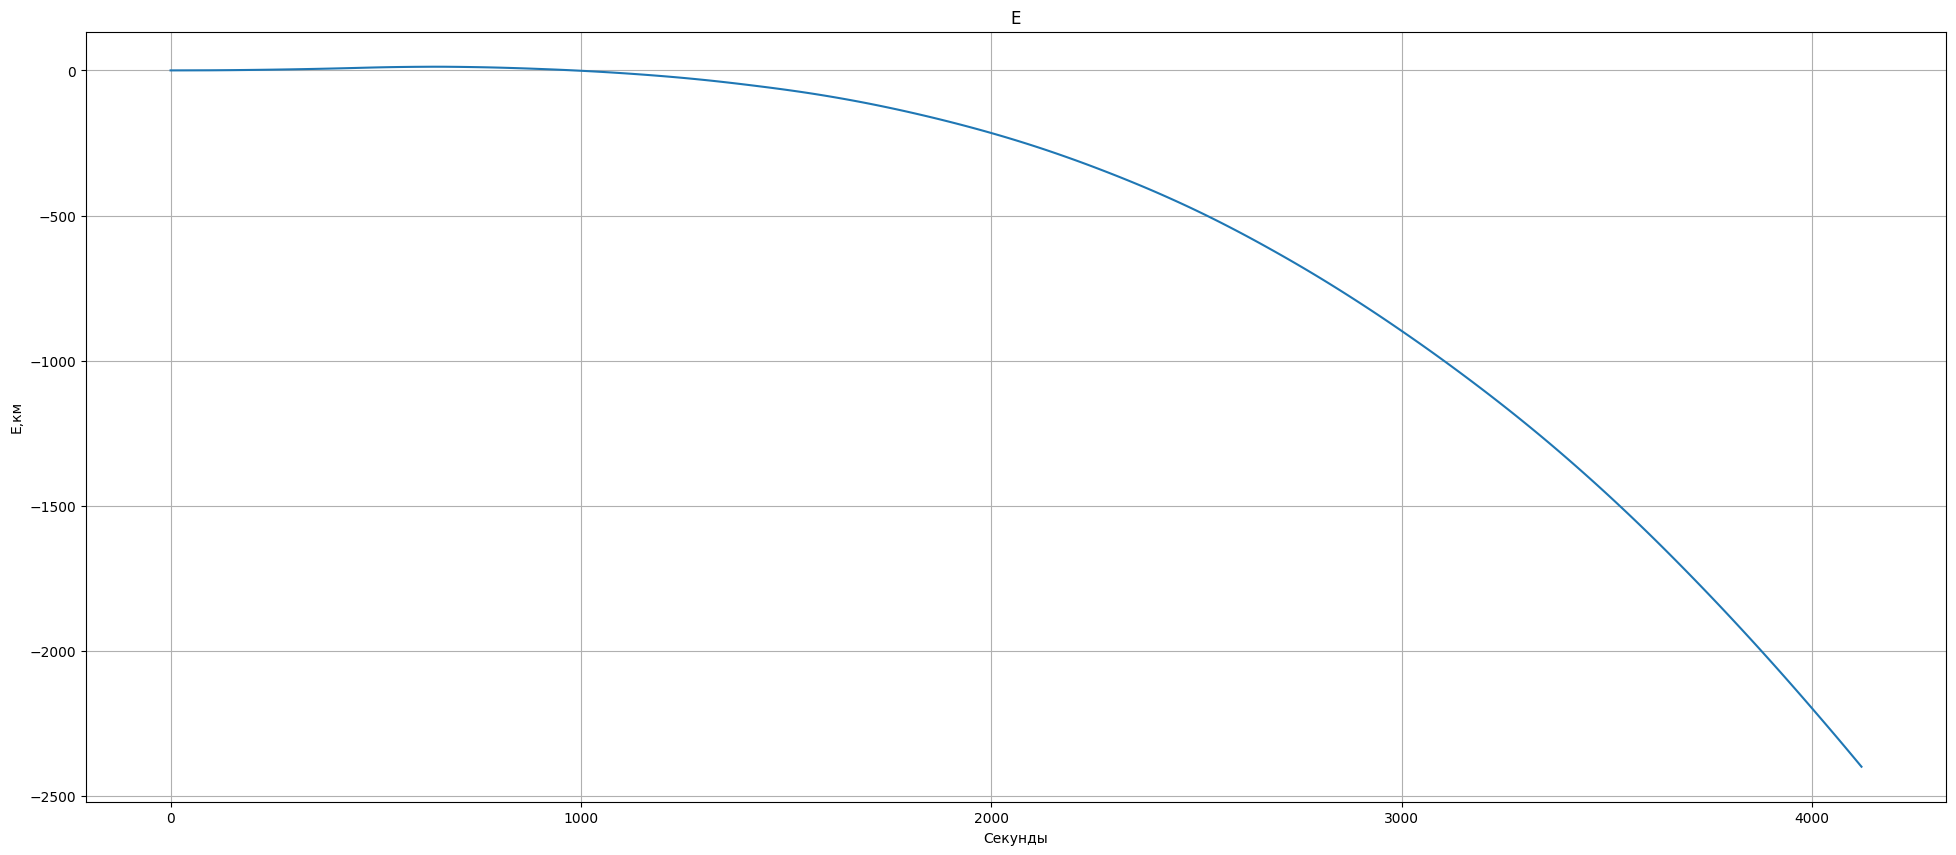

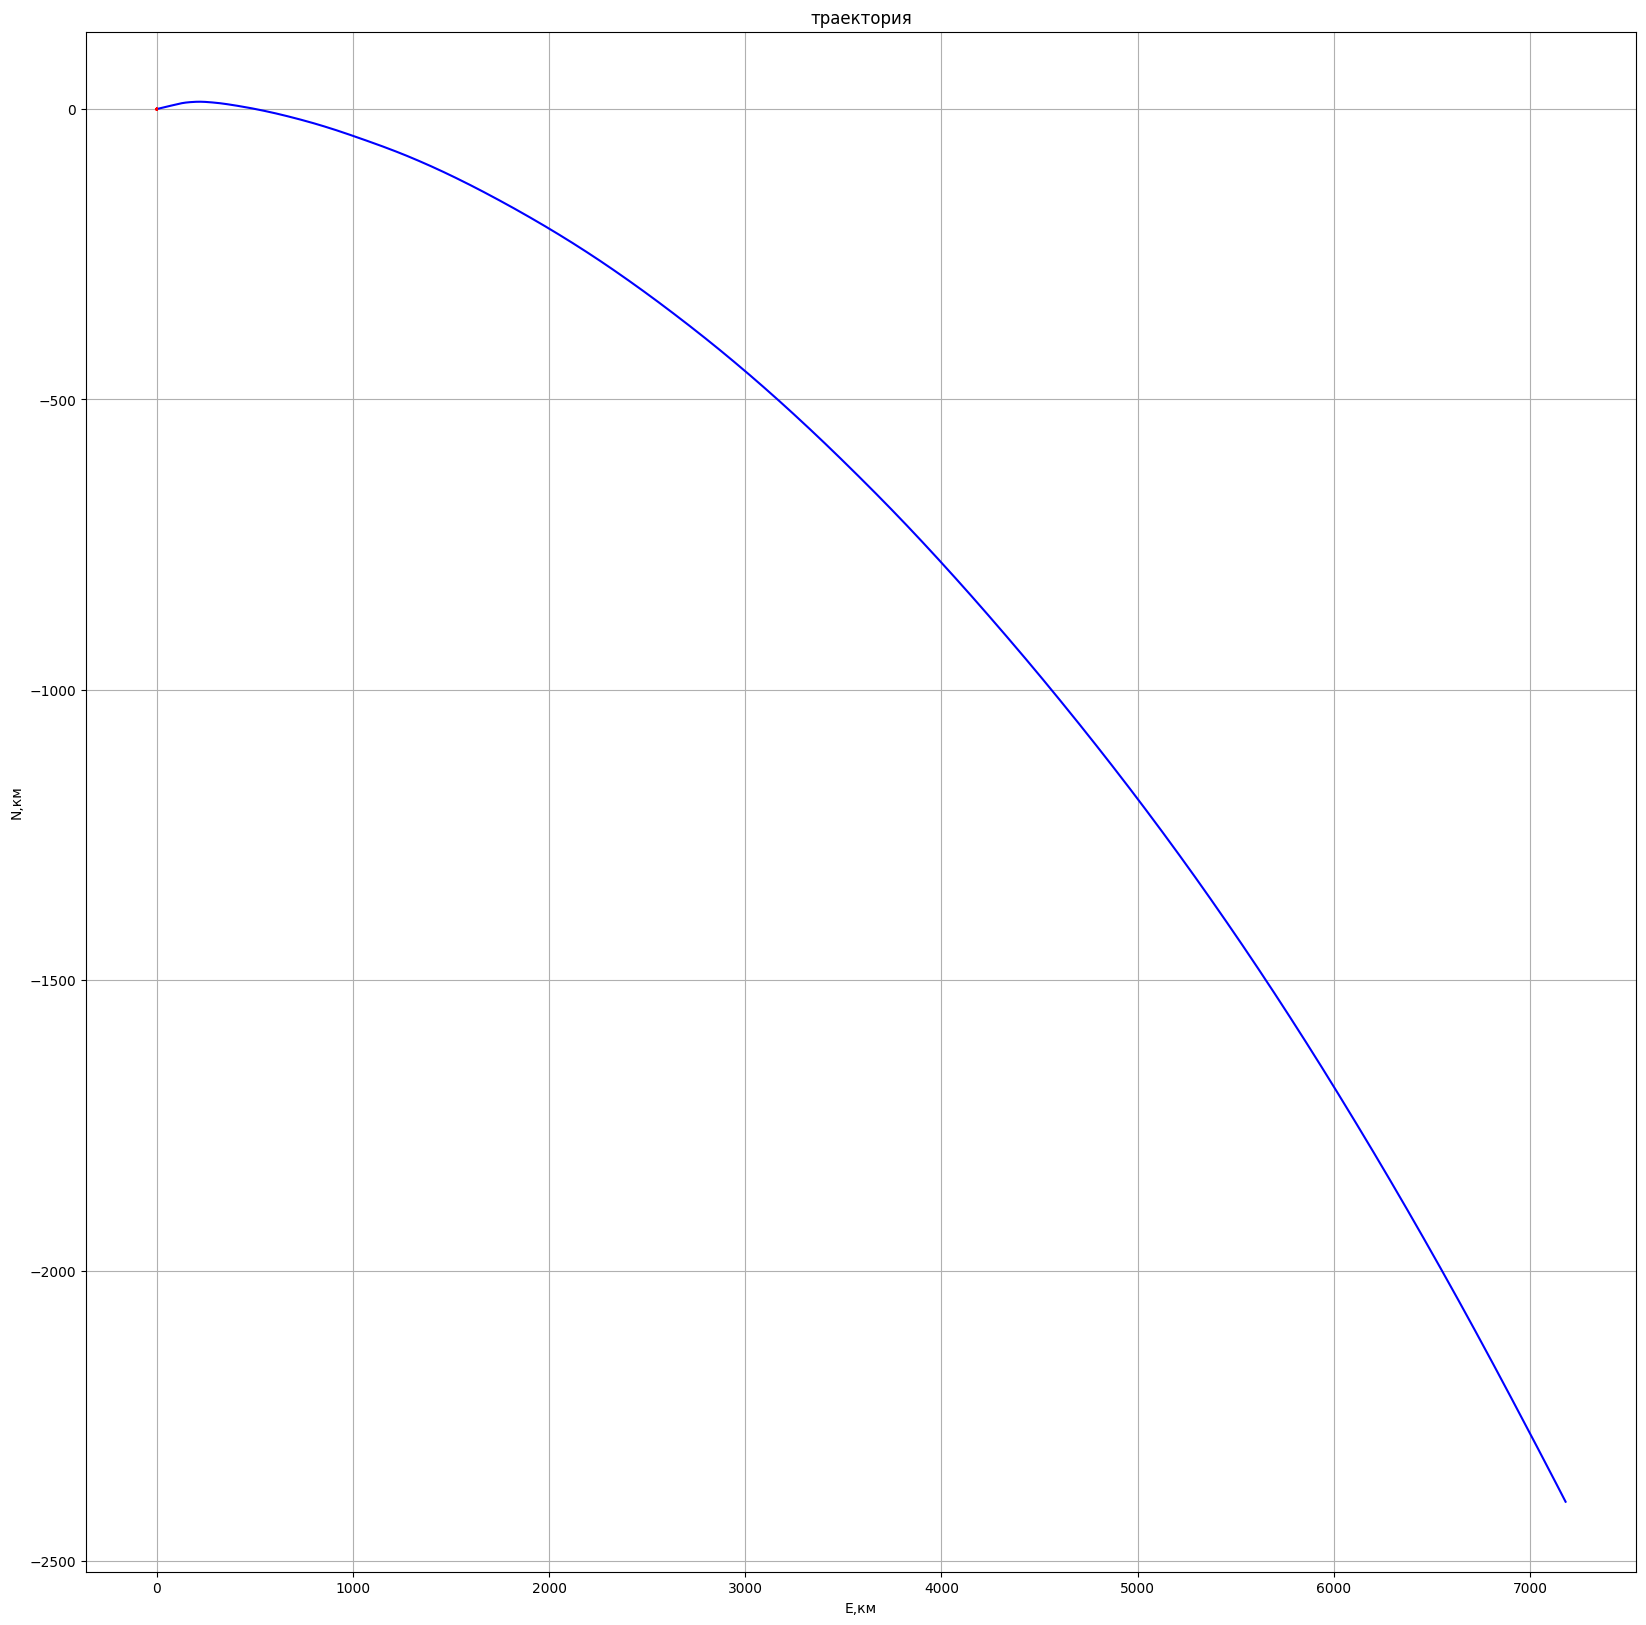

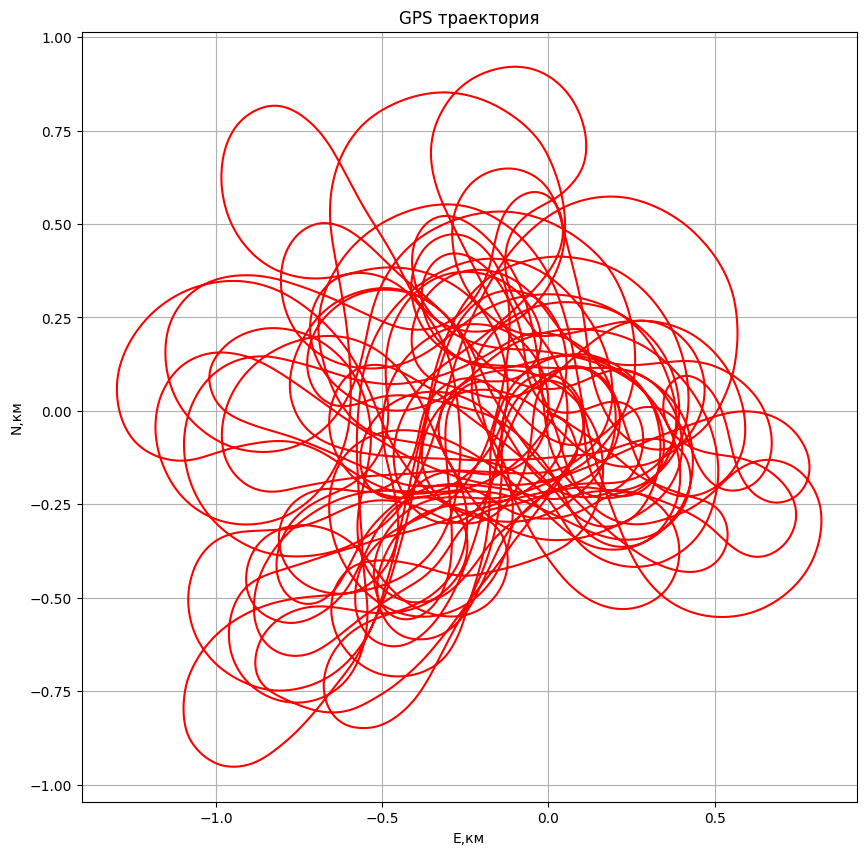

In [69]:
plt.figure(1)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_queue_Lat,'b')
plt.plot(t,out_queue_GPS_Lat,'r')
plt.title("Широта")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(2)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_queue_Lon,'b')
plt.plot(t,out_queue_GPS_Lon,'r')
plt.title("Долгота")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(3)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_queue_pitch)
plt.title("Тангаж")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(4)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_queue_roll)
plt.title("Крен")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(5)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_queue_heading)
plt.title("Курс")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(6)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_queue_W_N,'b')
plt.plot(t,out_queue_GPS_W_N,'r')
plt.title("Скорость N")
plt.xlabel('Cекунды')
plt.ylabel('м/c')
plt.grid(True)
plt.show()

plt.figure(7)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_queue_W_E,'b')
plt.plot(t,out_queue_GPS_W_E,'r')
plt.title("Скорость E")
plt.xlabel('Cекунды')
plt.ylabel('м/c')
plt.grid(True)
plt.show()

R = 6356.863 # км
out_queue_x = (out_queue_Lat * ((np.pi / 180) * R)) - (out_queue_Lat[0] * ((np.pi / 180) * R))
out_queue_y = (out_queue_Lon * (np.pi / 180) * (R * np.cos(Lat))) - (out_queue_Lon[0] * np.pi / 180 * (R * np.cos(Lat)))
out_queue_x_gps = (out_queue_GPS_Lat * ((np.pi / 180) * R)) - (out_queue_GPS_Lat[0] * ((np.pi / 180) * R))
out_queue_y_gps = (out_queue_GPS_Lon * (np.pi / 180) * (R * np.cos(Lat))) - (out_queue_GPS_Lon[0] * np.pi / 180 * (R * np.cos(Lat)))
plt.figure(9)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_queue_x[:N])
plt.title("N")
plt.xlabel('Cекунды')
plt.ylabel('N,км')
plt.grid(True)
plt.show()

plt.figure(10)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_queue_y[:N])
plt.title("E")
plt.xlabel('Cекунды')
plt.ylabel('E,км')
plt.grid(True)
plt.show()

plt.figure(11)
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.plot(out_queue_x[:N],out_queue_y[:N],'b')
plt.plot(out_queue_x_gps[:N],out_queue_y_gps[:N],'r')
plt.title("траектория")
plt.xlabel('E,км')
plt.ylabel('N,км')
plt.grid(True)
plt.show()

plt.figure(12)
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.plot(out_queue_x_gps[:N],out_queue_y_gps[:N],'r')
plt.title("GPS траектория")
plt.xlabel('E,км')
plt.ylabel('N,км')
plt.grid(True)
plt.show()